# Import Library

In [70]:
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Load Data

In [71]:
DATASET_PATH = 'dataset'
data_dir = pathlib.Path(DATASET_PATH)

# Data Splitting

In [75]:
train_dataset, val_dataset = tf.keras.utils.audio_dataset_from_directory(
    directory = data_dir,
    seed = 0,
    validation_split=0.3,
    subset="both",
    output_sequence_length=16000,
    batch_size=64
)

Found 6505 files belonging to 4 classes.
Using 4554 files for training.
Using 1951 files for validation.


In [ ]:
label_names = np.array(train_dataset.class_names)
print (label_names)
num_labels = len(label_names)
print (num_labels)

['follow' 'learn' 'tree' 'visual']
4


# Squeezing

In [78]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

In [79]:
train_dataset = train_dataset.map(squeeze, tf.data.AUTOTUNE)
val_dataset = val_dataset.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Create Testing Data

In [81]:
test_dataset = val_dataset.shard(num_shards=2, index=0)
val_dataset = val_dataset.shard(num_shards=2, index=1)

In [82]:
test_dataset

<_ShardDataset element_spec=(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Generate the Spectogram Data

In [ ]:
def get_spectogram(waveform):

    spectogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectogram = tf.abs(spectogram)
    spectogram = spectogram[..., tf.newaxis]
    return spectogram


In [53]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectogram(audio), label),
        num_parallel_calls = tf.data.AUTOTUNE
    )

# Convert Audio Array to Spectogram

In [87]:
train_spectogram_ds = make_spec_ds(train_dataset)
test_spectogram_ds = make_spec_ds(test_dataset)
val_spectogram_ds = make_spec_ds(val_dataset)

In [88]:
# cache, prefetch, autotune
train_spectogram_ds = train_spectogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectogram_ds = val_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectogram_ds = test_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# Build Model

In [89]:
for exmp_spectogram, exmp_spect_labels in train_spectogram_ds.take(1):
    break

In [90]:
input_shape = exmp_spectogram.shape[1:]

In [ ]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectogram_ds.map(
    map_func=lambda spec, label : spec
))

In [59]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

In [94]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_3 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,375 (1.20 MB)

 Trainable params: 314,372 (1.20 MB)

 Non-trainable params: 3 (16.00 B)

In [95]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train Model

In [96]:
EPOCHS = 10

history = model.fit(
    train_spectogram_ds,
    validation_data = val_spectogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(
        verbose=1, patience=2
    )
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5570 - loss: 1.0355 - val_accuracy: 0.8052 - val_loss: 0.5450
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8120 - loss: 0.5375 - val_accuracy: 0.8552 - val_loss: 0.4505
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8633 - loss: 0.4026 - val_accuracy: 0.8792 - val_loss: 0.3714
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8918 - loss: 0.3366 - val_accuracy: 0.8917 - val_loss: 0.3495
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8855 - loss: 0.3060 - val_accuracy: 0.8969 - val_loss: 0.3126
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9125 - loss: 0.2711 - val_accuracy: 0.9052 - val_loss: 0.2762
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9217 - loss: 0.2331 - val_accuracy: 0.9052 - val_loss: 0.2980
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9226 - loss: 0.2208 - val_accuracy: 0.9187 - v

# Evaluate Model

Text(0, 0.5, 'Accuracy[%]')

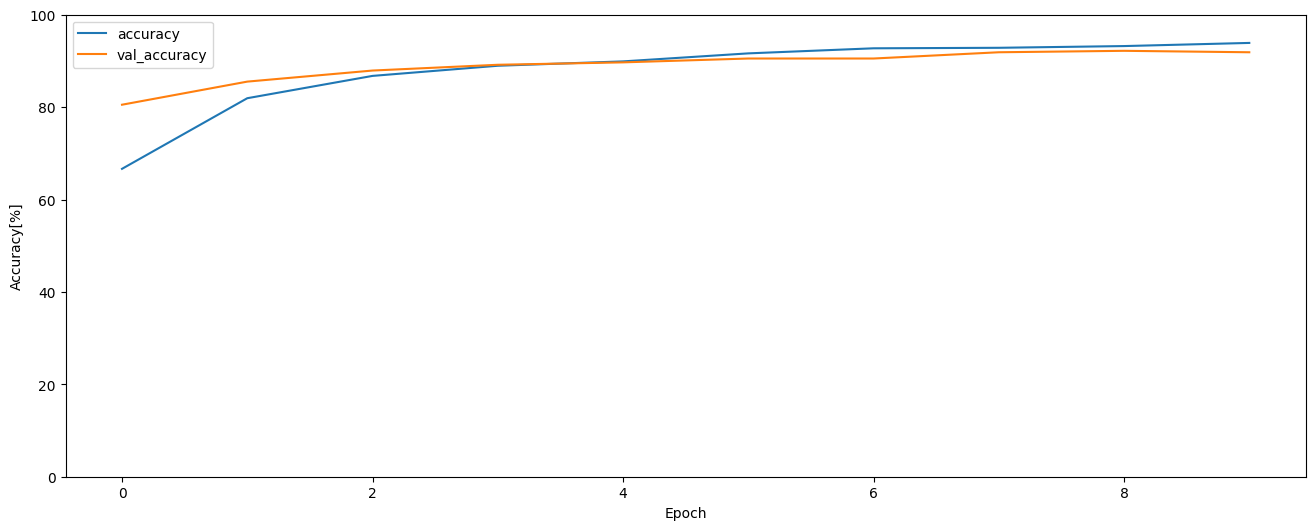

In [99]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.plot(history.epoch, 100*np.array(metrics["accuracy"]), 100*np.array(metrics["val_accuracy"]))
plt.legend(["accuracy", "val_accuracy"])
plt.ylim(0,100)
plt.xlabel("Epoch")
plt.ylabel("Accuracy[%]")

In [100]:
test_results = model.evaluate(test_spectogram_ds, return_dict=True)
accuracy = test_results["accuracy"]
print (f"Accuracy  on test set = {accuracy*100:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9221 - loss: 0.2253
Accuracy  on test set = 92.84


# Predict

In [66]:
ctr = 0

for i, (spectogram, label) in enumerate(test_spectogram_ds):
    pred = model.predict(spectogram)
    pred_label_idx = tf.argmax(pred, axis=1).numpy()
    orig_label = label_names[label.numpy()]
    pred_label = [label_names[idx] for idx in pred_label_idx]
    for j, label in enumerate(orig_label):
        ctr += 1
        print ("Data %d: Original Label -> %s, Prediction -> %s" % (ctr, label, pred_label[j]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Data 1: Original Label -> tree, Prediction -> tree
Data 2: Original Label -> learn, Prediction -> learn
Data 3: Original Label -> tree, Prediction -> tree
Data 4: Original Label -> tree, Prediction -> tree
Data 5: Original Label -> tree, Prediction -> tree
Data 6: Original Label -> visual, Prediction -> visual
Data 7: Original Label -> tree, Prediction -> tree
Data 8: Original Label -> visual, Prediction -> visual
Data 9: Original Label -> learn, Prediction -> learn
Data 10: Original Label -> visual, Prediction -> visual
Data 11: Original Label -> visual, Prediction -> visual
Data 12: Original Label -> follow, Prediction -> follow
Data 13: Original Label -> learn, Prediction -> learn
Data 14: Original Label -> tree, Prediction -> tree
Data 15: Original Label -> tree, Prediction -> tree
Data 16: Original Label -> visual, Prediction -> visual
Data 17: Original Label -> tree, Prediction -> tree
Data 18: Original Label -> tree, Prediction -> tree
Data 